In [1]:
import numpy as np
import torch
import ot
import ot.plot
import matplotlib.pyplot as plt
from smoothot.dual_solvers import solve_dual, solve_semi_dual
from smoothot.dual_solvers import NegEntropy, SquaredL2
from smoothot.dual_solvers import get_plan_from_dual, get_plan_from_semi_dual
from sparse_ot.sparseotdash_full_k import get_gamma
from sparse_ot.orig_mmd_ot import solve_apgd
from sparse_ot.utils import get_G, get_dist, seed, get_topk_plan

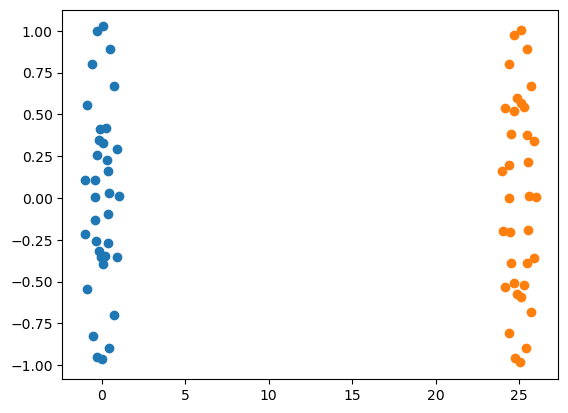

In [2]:
from sklearn import datasets
n_samples=35
x, _ = datasets.make_circles(n_samples=n_samples, factor=0.4, noise=0.03, random_state=0)

y, _ = datasets.make_circles(n_samples=n_samples, factor=0.6, noise=0.01, random_state=0)
y[:, 0] += 25

plt.clf()
plt.scatter(x[:, 0], x[:, 1])
plt.scatter(y[:, 0], y[:, 1])
plt.show()

In [3]:
m = x.shape[0]
n = y.shape[0]

In [4]:
device = torch.device("cpu")

khp = 1e-1
ktype = "rbf"
d_noise = 10


x_t = torch.from_numpy(x).to(device)
y_t = torch.from_numpy(y).to(device)

a = ot.unif(x.shape[0])

b = ot.unif(y.shape[0])

a_t = torch.from_numpy(a).to(device)
b_t = torch.from_numpy(b).to(device)

C_t = get_dist(x_t, y_t)
C = C_t.to("cpu").numpy()

G1 = get_G(x_t, x_t, khp, ktype)
G2 = get_G(y_t, y_t, khp, ktype)

print(torch.linalg.cond(G1), torch.linalg.cond(G2))

tensor(7.4750, dtype=torch.float64) tensor(1.6114, dtype=torch.float64)


In [9]:
def show(pi, x, y, save_as=None):
    pi = pi/np.max(pi)
    
    plt.rcParams["figure.figsize"] = (8,3)
    ot.plot.plot2D_samples_mat(x, y, pi, color=[.5, .5, 1])
    plt.plot(x[:, 0], x[:, 1], '+b', label='Source samples')
    plt.plot(y[:, 0], y[:, 1], 'xr', label='Target samples')
    plt.legend(loc="upper left")
    if save_as is not None:
        plt.savefig(save_as, bbox_inches = 'tight', pad_inches = 0.25)
    plt.show()
    plt.close()
    print("No. of non-zeros = {}".format((np.where(pi)[0]).shape[0]))


def get_marginals(arr):
    m1 = arr.sum(axis=1)
    m2 = arr.sum(axis=0)
    return m1, m2

def quant_plan(T, C, a, b):
    print("rank = {}".format(np.linalg.matrix_rank(T)))
    ix = np.where(T)
    pos = np.array(list(zip(ix[0], ix[1])))
    distances = pdist(pos, metric="euclidean")
    print(np.sum(squareform(distances))/(m*n))
    
    print("E[C] = {}".format(np.sum(T*C)))
    m1, m2 = get_marginals(T)
    print(np.linalg.norm(m1-a))
    print(np.linalg.norm(m2-b))
    
from scipy.spatial.distance import pdist, squareform

    
max_itr = 100

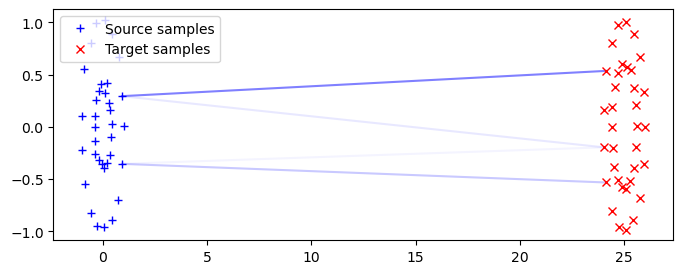

No. of non-zeros = 4
rank = 2
0.20943935393517005
E[C] = 615.2808026982909
0.847637124029724
0.7329986512006066


In [10]:
regul = SquaredL2(gamma=1.0)
alpha, beta = solve_dual(a, b, C, regul, max_iter=100)
T = get_plan_from_dual(alpha, beta, C, regul)

show(T, x, y, "ex2_sms.jpg")
quant_plan(T, C, a, b)

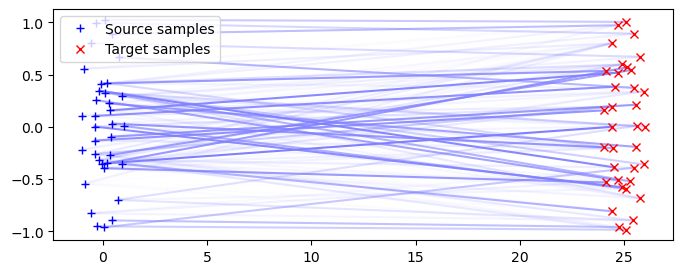

No. of non-zeros = 241
rank = 33
810.8503158679277
E[C] = 0.3204058098445644
0.10951308535918985
0.1061804940234915


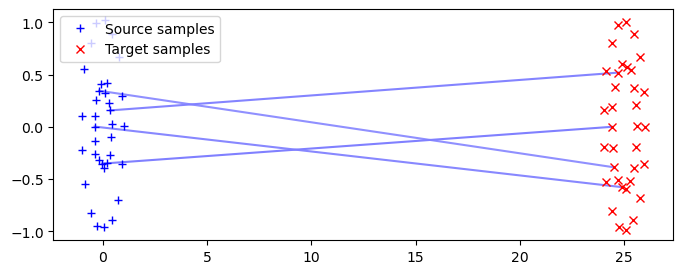

No. of non-zeros = 4
rank = 4
0.14717734655981193
E[C] = 0.08624313695654011
0.15919721967714898
0.15919721967714898


In [11]:
C_g = C_t/C_t.max()
lda = 10

gamma_su = get_gamma(C_g, G1, G2, a_t, b_t, max_itr, lda).numpy()
show(gamma_su, x, y, "ex2_gsu.jpg")#, save_as="suot_nz_l2.jpg")
quant_plan(gamma_su, C_g.numpy(), a, b)

gamma_suk = get_gamma(C_g, G1, G2, a_t, b_t, max_itr, lda, K=np.where(T)[0].shape[0]).numpy()
show(gamma_suk, x, y, "ex2_gsuk.jpg")#, save_as="suot_nz_l2.jpg")
quant_plan(gamma_suk, C_g.numpy(), a, b)

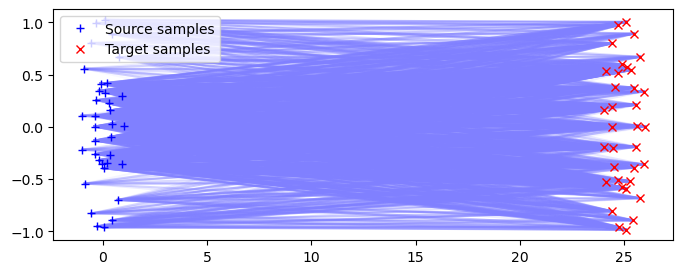

No. of non-zeros = 924
rank = 28
12643.924973153835
E[C] = 0.3141475000037616
0.11095760068194398
0.1072961142720802


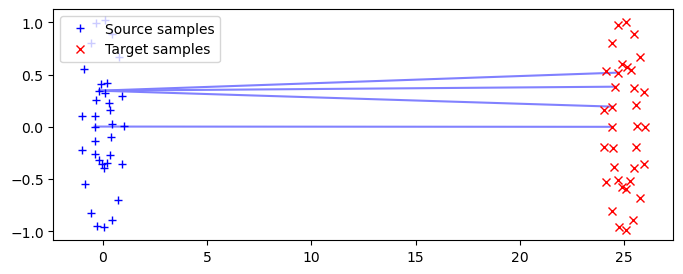

No. of non-zeros = 4


In [12]:
gamma_u = solve_apgd(C_g, G1, G2, a_t, b_t, max_itr, lda)
show(gamma_u.numpy(), x, y, "ex2_gu.jpg")#, save_as="suot_nz_l2.jpg")
quant_plan(gamma_u.numpy(), C_g.numpy(), a, b)

show(get_topk_plan(gamma_u, np.where(T)[0].shape[0]), x, y, "ex2_guk.jpg")